In [1]:
import os
import csv
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from tqdm import tqdm
#import argparse

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.utils import save_image

matplotlib.style.use('ggplot')

torch.cuda.empty_cache() 
#import model

import ast

In [2]:
class ActiveVisionDataset (Dataset):
    def __init__(self, csv_file, root_dir, transforms=None):
        self.annotations = pd.read_csv(csv_file, index_col=None)
        self.root_dir = root_dir
        self.transforms = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Resize((128,128)),
                              transforms.RandomRotation(50,expand=False),  
                              transforms.Resize((128,128)),
                              transforms.ToTensor(),
                              ])
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        if type(index) == torch.Tensor:
            index = index.item()
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        #image = image/(image.max()/255.0)
        shape_label = torch.tensor(int(self.annotations.iloc[index,1]))
        #print(shape_label)
        cam_loc = torch.tensor(ast.literal_eval(self.annotations.iloc[index,2]))
#         print(cam_loc)
        cam_loc = torch.tensor([cam_loc[1], cam_loc[2]])
#         print(cam_loc)
        if self.transforms:
            image = self.transforms(image)
        
        return image, shape_label, cam_loc
    

In [3]:
batch_size = 4

# train_data = ActiveVisionDataset(csv_file='generation/DualReconstructionProcedural1000/rgbCSVgenerated.csv', root_dir='generation/DualReconstructionProcedural1000/generated/', transform = torchvision.transforms.ToTensor())
# trainloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

set_used = 'datasets/SmallProcedural'

train_data = ActiveVisionDataset(csv_file=set_used+'/TrainSet/rgbCSV.csv', root_dir=set_used+'/TrainSet/rgbImg/', transforms = torchvision.transforms)
trainloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

val_data = ActiveVisionDataset(csv_file=set_used+'/ValSet/rgbCSV.csv', root_dir= set_used+'/ValSet/rgbImg/', transforms = torchvision.transforms)
testloader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

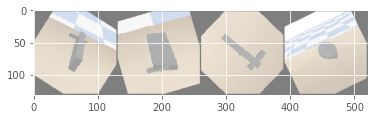

4 1 4 0


In [4]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels, _ = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(13456, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, _ = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


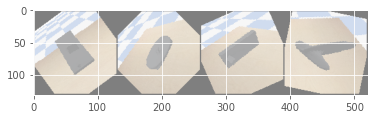

GroundTruth:  3 0 4 2


In [8]:
dataiter = iter(testloader)
images, labels, _ = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(4)))

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels, _ = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 38 %
